In [1]:
# run this before opening this file ni to ni chalega kuch bhi
# jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [4]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.utils import to_categorical
from keras.layers import concatenate
from keras.models import load_model
from tqdm.notebook import tqdm #to check loop progress
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import keras

## Data Cleaning Of Descriptions

### these functions helps to do so .

In [10]:
# Load the document file into memory
def load_fp(filename):
  # Open file to read
   file = open(filename, 'r')
   text = file.read()
   file.close()
   return text

In [22]:
# get all images with their captions
def img_capt(filename):
    file = load_fp(filename)
    # print(file)
    captions = file.split('\n')
    descriptions ={}
    # print(captions)
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
                   descriptions[img[:-2]] = [ caption ]
        else:
                   descriptions[img[:-2]].append(caption)
    return descriptions

In [24]:
#Data cleaning function will convert all upper case alphabets to lowercase, removing punctuations and words containing numbers
def txt_clean(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
           img_caption.replace("-"," ")
           descp = img_caption.split()
           #uppercase to lowercase
           descp = [wrd.lower() for wrd in descp]
           #remove punctuation from each token
           descp = [wrd.translate(table) for wrd in descp]
           #remove hanging 's and a
           descp = [wrd for wrd in descp if(len(wrd)>1)]
           #remove words containing numbers with them
           descp = [wrd for wrd in descp if(wrd.isalpha())]
           #converting back to string
           img_caption = ' '.join(descp)
           captions[img][i]= img_caption
    return captions

In [5]:
def txt_vocab(descriptions):
    # To build vocab of all unique words
    vocab = set()
    for key in descriptions.keys():
           [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

In [30]:
#To save all descriptions in one file
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
               lines.append(key + '\t' + desc )
        data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [31]:
# Set these path according to project folder in you system, like i create a folder with my name shikha inside D-drive
dataset_text = "D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning\Flickr8k_text"
dataset_images = "D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning\Flickr8k_Dataset"
#to prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#map them into descriptions dictionary 
descriptions = img_capt(filename)
print("Length of descriptions =" ,len(descriptions))
#cleaning the descriptions
clean_descriptions = txt_clean(descriptions)
#to build vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
#saving all descriptions in one file
save_descriptions(clean_descriptions, "descriptions.txt")
# print(clean_descriptions)

Length of descriptions = 8092
Length of vocabulary =  8763


In [32]:
vocabulary

{'cellphone',
 'kisses',
 'trip',
 'hide',
 'pane',
 'dinghy',
 'been',
 'cruise',
 'go',
 'polar',
 'buzy',
 'dance',
 'harly',
 'stopped',
 'handlebars',
 'sled',
 'occupied',
 'memorial',
 'hiking',
 'beaded',
 'effects',
 'bloodied',
 'streambed',
 'learns',
 'bean',
 'words',
 'ones',
 'bar',
 'onehanded',
 'dimpled',
 'obese',
 'age',
 'bites',
 'ping',
 'terriers',
 'violin',
 'pajamas',
 'secluded',
 'dojo',
 'waterboard',
 'tented',
 'trained',
 'crowded',
 'fluid',
 'atrium',
 'lioness',
 'shamrocks',
 'legged',
 'others',
 'path',
 'folding',
 'lounging',
 'motorbiker',
 'gnarly',
 'wizard',
 'movie',
 'laughs',
 'angel',
 'rates',
 'wakeboards',
 'created',
 'cavern',
 'bath',
 'dropping',
 'tartan',
 'mural',
 'foam',
 'billowing',
 'bakery',
 'recliner',
 'mountaintops',
 'goldcolored',
 'oppenents',
 'citizens',
 'opinion',
 'dog',
 'turns',
 'well',
 'brawl',
 'pasts',
 'caution',
 'array',
 'crazily',
 'ripping',
 'halfdressed',
 'handout',
 'share',
 'mouths',
 'rocky

## Loading Data and Model for training

### we have a file which has the data to train so we will be using that only bro
### we are also extracting and storing all the features in a pickle file so we don't have to repeat all this if we want to run the file again.

In [35]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 96s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [39]:
# extract features from image
features = {}
directory = os.path.join("D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning\Flickr8k_Dataset", 'Flicker8k_Dataset')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = os.path.join(directory,img_name)
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature
    # print(img_path)

  0%|          | 0/8091 [00:00<?, ?it/s]

In [41]:
# store features in pickle
dump(features, open(os.path.join("D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning", 'features.pkl'), 'wb'))

In [89]:
# this is for further use i am renaming some of the variables which i have made
mapping = {}
for key in clean_descriptions.keys():
    temp = ["startseq "+d+" endseq" for d in clean_descriptions[key]]
    mapping[key] = temp

In [90]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [91]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [92]:
vocab_size

8766

In [93]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

In [8]:
#load the data
def load_photos(filename):
    file = load_fp(filename)
    photos = file.split("\n")[:-1]
    photos = [img.split(".")[0] for img in photos] 
    return photos

# load features from pickle
def load_features(filename):
    with open(filename, 'rb') as f:
        features = load(f)
    return features

In [95]:
train = load_photos("D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning\Flickr8k_text\Flickr_8k.trainImages.txt")
features = load_features(os.path.join("D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning","features.pkl"))
test = load_photos("D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning\Flickr8k_text\Flickr_8k.testImages.txt")

In [96]:
print(type(features))
print(features.keys())

<class 'dict'>
dict_keys(['1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8', '1003163366_44323f5815', '1007129816_e794419615', '1007320043_627395c3d8', '1009434119_febe49276a', '1012212859_01547e3f17', '1015118661_980735411b', '1015584366_dfcec3c85a', '101654506_8eb26cfb60', '101669240_b2d3e7f17b', '1016887272_03199f49c4', '1019077836_6fc9b15408', '1019604187_d087bf9a5f', '1020651753_06077ec457', '1022454332_6af2c1449a', '1022454428_b6b660a67b', '1022975728_75515238d8', '102351840_323e3de834', '1024138940_f1fefbdce1', '102455176_5f8ead62d5', '1026685415_0431cbf574', '1028205764_7e8df9a2ea', '1030985833_b0902ea560', '103106960_e8a41d64f8', '103195344_5d2dc613a3', '103205630_682ca7285b', '1032122270_ea6f0beedb', '1032460886_4a598ed535', '1034276567_49bb87c51c', '104136873_5b5d41be75', '1042020065_fb3d3ba5ba', '1042590306_95dea0916c', '1045521051_108ebc19be', '1048710776_bb5b0a5c7c', '1052358063_eae6744153', '105342180_4d4a40b47f', '1053804096_ad278b25f1', '1055623

In [97]:
print(train)

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154', '2851304910_b5721199bc', '3423802527_94bd2b23b0', '3356369156_074750c6cc', '2294598473_40637b5c04', '1191338263_a4fa073154', '2380765956_6313d8cae3', '3197891333_b1b0fd1702', '3119887967_271a097464', '2276499757_b44dc6f8ce', '2506892928_7e79bec613', '2187222896_c206d63396', '2826769554_85c90864c9', '3097196395_ec06075389', '3603116579_4a28a932e2', '3339263085_6db9fd0981', '2532262109_87429a2cae', '2076906555_c20dc082db', '2502007071_82a8c639cf', '3113769557_9edbb8275c', '3325974730_3ee192e4ff', '1655781989_b15ab4cbff', '1662261486_db967930de', '2410562803_56ec09f41c', '2469498117_b4543e1460', '69710415_5c2bfb1058', '3414734842_beb543f400', '3006217970_90b42e6b27', '2192411521_9c7e488c5e', '3535879138_9281dc83d5', '2685788323_ceab14534a', '34

In [98]:
print(mapping.keys())

dict_keys(['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg', '1002674143_1b742ab4b8.jpg', '1003163366_44323f5815.jpg', '1007129816_e794419615.jpg', '1007320043_627395c3d8.jpg', '1009434119_febe49276a.jpg', '1012212859_01547e3f17.jpg', '1015118661_980735411b.jpg', '1015584366_dfcec3c85a.jpg', '101654506_8eb26cfb60.jpg', '101669240_b2d3e7f17b.jpg', '1016887272_03199f49c4.jpg', '1019077836_6fc9b15408.jpg', '1019604187_d087bf9a5f.jpg', '1020651753_06077ec457.jpg', '1022454332_6af2c1449a.jpg', '1022454428_b6b660a67b.jpg', '1022975728_75515238d8.jpg', '102351840_323e3de834.jpg', '1024138940_f1fefbdce1.jpg', '102455176_5f8ead62d5.jpg', '1026685415_0431cbf574.jpg', '1028205764_7e8df9a2ea.jpg', '1030985833_b0902ea560.jpg', '103106960_e8a41d64f8.jpg', '103195344_5d2dc613a3.jpg', '103205630_682ca7285b.jpg', '1032122270_ea6f0beedb.jpg', '1032460886_4a598ed535.jpg', '1034276567_49bb87c51c.jpg', '104136873_5b5d41be75.jpg', '1042020065_fb3d3ba5ba.jpg', '1042590306_95dea0916c.jpg', '1045521051

In [13]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            temp = key+".jpg"
            captions = mapping[temp]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0

In [100]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(model.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 34)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_3 (InputLayer)    │ (None, 4096)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 34, 256)           │       2,244,096 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 4096)              │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 34, 256)           │               0 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_1 (NotEqual)        │ (None, 34)                │               0 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 256)               │       1,048,832 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 256)               │         525,312 │ dropout_3[0][0],           │
│                               │                           │                 │ not_equal_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 256)               │               0 │ dense_3[0][0],             │
│                               │                           │                 │ lstm_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 256)               │          65,792 │ add_1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 8766)              │       2,252,862 │ dense_4[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 6,136,894 (23.41 MB)

 Trainable params: 6,136,894 (23.41 MB)

 Non-trainable params: 0 (0.00 B)

None


In [101]:
# plot the model
plot_model(model, to_file ='model.png', show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [11]:
# to load a pre saved model

# model = keras.models.load_model(os.path.join("D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning","best_model.keras"))

# train = load_photos("D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning\Flickr8k_text\Flickr_8k.trainImages.txt")
# features = load_features(os.path.join("D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning","features.pkl"))
# test = load_photos("D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning\Flickr8k_text\Flickr_8k.testImages.txt")

In [24]:
# train the model
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model1 = Model(inputs=[inputs1, inputs2], outputs=outputs)
model1.compile(loss='categorical_crossentropy', optimizer='adam')

epochs = 1
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # print(generator)
    # fit for one epoch
    model1.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

93/93 ━━━━━━━━━━━━━━━━━━━━ 438s 5s/step - loss: 6.2656


In [25]:
# save the model
model1.save(os.path.join("D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning","temp_model.keras"))
model1.save(os.path.join("D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning","temp_model.h5"))

## Now let's do some predictions bro

In [26]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [27]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [28]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name,model):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning\Flickr8k_Dataset\Flicker8k_Dataset", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id+".jpg"]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq boy descends off the end of high diving board endseq
startseq child jumps off high diving board into the pool endseq
startseq kid jumps off the diving board and into the swimming pool below endseq
startseq little kid is jumping off high dive at the pool endseq
startseq the boy is jumping off high diving board into the pool endseq
--------------------Predicted--------------------
startseq the the in in water water endseq


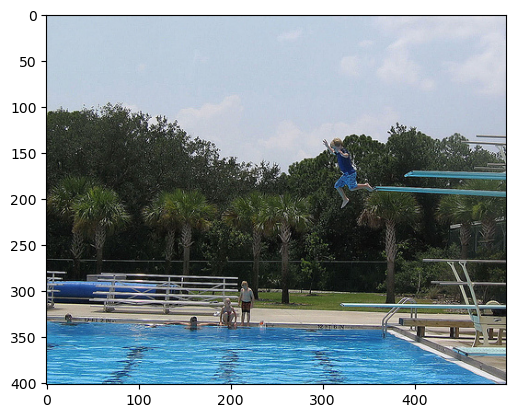

In [29]:
generate_caption("1057089366_ca83da0877.jpg",model1)

---------------------Actual---------------------
startseq group of backpackers lay on the dry ground endseq
startseq group of hikers are resting on the ground in front of some mountains endseq
startseq people camp with the mountains in the background endseq
startseq several hikers rest with their gear in front of mountain endseq
startseq the group of hikers is resting in front of mountain endseq
--------------------Predicted--------------------
startseq people people in the endseq


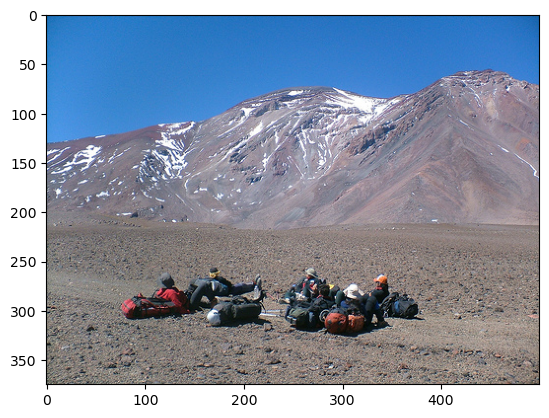

In [30]:
generate_caption("1093716555_801aacef79.jpg",model1)

---------------------Actual---------------------
startseq boy lays on picnic table bench endseq
startseq child is laying down on wooden bench endseq
startseq child is on bench with arms stretched out endseq
startseq little boy in red shirt sitting on wooden picnic table bench endseq
startseq little boy lies down on picnic table bench endseq
--------------------Predicted--------------------
startseq boy in on endseq


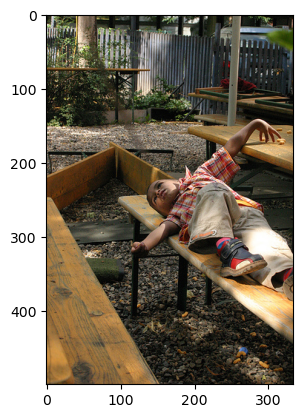

In [31]:
generate_caption("1204996216_71d7519d9a.jpg",model1)

---------------------Actual---------------------
startseq dog in number six jersey is running through field endseq
startseq dog is leaping through the grass endseq
startseq dog is wearing red number and running through field of green grass while being chased by bird endseq
startseq white and tan dog leaps through the air endseq
startseq the dog in vest leaps in the air and there is bird flying endseq
--------------------Predicted--------------------
startseq dog running ball endseq


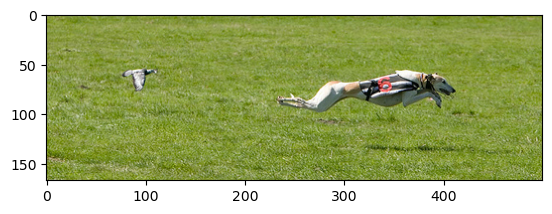

In [32]:
generate_caption("1240297429_c36ae0c58f.jpg",model1)

---------------------Actual---------------------
startseq lady holds little girl who is trying to catch bubbles endseq
startseq woman is holding little girl who is trying to catch bubbles endseq
startseq woman with holding young girl playing with bubbles at picnic endseq
startseq young woman in blue shirt stands holding young girl in denim dress endseq
startseq there is woman holding her baby daughter while the daughter claps endseq
--------------------Predicted--------------------
startseq girl in in endseq


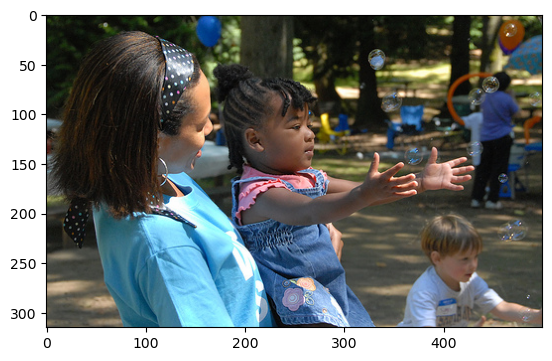

In [33]:
generate_caption("1237985362_dbafc59280.jpg",model1)

---------------------Actual---------------------
startseq smiling girls in bathing suits sitting on the sand endseq
startseq group of friends smile for picture at the beach endseq
startseq group of young ladies in bikinis endseq
startseq the three girls in bathing suits are all smiles endseq
startseq the three girls sat on the beach endseq
--------------------Predicted--------------------
startseq girl in in in endseq


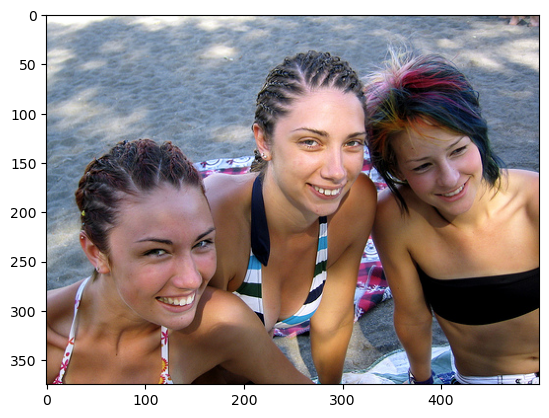

In [34]:
generate_caption("1244306891_8e78ae1620.jpg",model1)

### now let's do some more serious testing bro

In [115]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key+".jpg"]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU-1: 0.521113
BLEU-2: 0.260876
BLEU-3: 0.118133
BLEU-4: 0.039375


## now i have trained the model once but if i want to train and use a presaved model let's see how we can do that bro 

In [3]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.utils import to_categorical
from keras.layers import concatenate
from keras.models import load_model
from tqdm.notebook import tqdm #to check loop progress
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import keras

In [4]:
# Load the document file into memory
def load_fp(filename):
  # Open file to read
   file = open(filename, 'r')
   text = file.read()
   file.close()
   return text
#load the data
def load_photos(filename):
    file = load_fp(filename)
    photos = file.split("\n")[:-1]
    photos = [img.split(".")[0] for img in photos] 
    return photos

# load features from pickle
def load_features(filename):
    with open(filename, 'rb') as f:
        features = load(f)
    return features

# get all images with their captions
def img_capt(filename):
    file = load_fp(filename)
    # print(file)
    captions = file.split('\n')
    descriptions ={}
    # print(captions)
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
                   descriptions[img[:-2]] = [ caption ]
        else:
                   descriptions[img[:-2]].append(caption)
    return descriptions

#Data cleaning function will convert all upper case alphabets to lowercase, removing punctuations and words containing numbers
def txt_clean(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
           img_caption.replace("-"," ")
           descp = img_caption.split()
           #uppercase to lowercase
           descp = [wrd.lower() for wrd in descp]
           #remove punctuation from each token
           descp = [wrd.translate(table) for wrd in descp]
           #remove hanging 's and a
           descp = [wrd for wrd in descp if(len(wrd)>1)]
           #remove words containing numbers with them
           descp = [wrd for wrd in descp if(wrd.isalpha())]
           #converting back to string
           img_caption = ' '.join(descp)
           captions[img][i]= img_caption
    return captions

In [5]:
train = load_photos("D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning\Flickr8k_text\Flickr_8k.trainImages.txt")
features = load_features(os.path.join("D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning","features.pkl"))
test = load_photos("D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning\Flickr8k_text\Flickr_8k.testImages.txt")

In [6]:
# Set these path according to project folder in you system, like i create a folder with my name shikha inside D-drive
dataset_text = "D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning\Flickr8k_text"
dataset_images = "D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning\Flickr8k_Dataset"
#to prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#map them into descriptions dictionary 
descriptions = img_capt(filename)
print("Length of descriptions =" ,len(descriptions))
#cleaning the descriptions
clean_descriptions = txt_clean(descriptions)

Length of descriptions = 8092


In [7]:
# this is for further use i am renaming some of the variables which i have made
mapping = {}
for key in clean_descriptions.keys():
    temp = ["startseq "+d+" endseq" for d in clean_descriptions[key]]
    mapping[key] = temp

In [8]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [9]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8766

In [10]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

In [11]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            temp = key+".jpg"
            captions = mapping[temp]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0

In [12]:
# to load a pre saved model

model = keras.models.load_model(os.path.join("D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning","best_model.keras"))

In [32]:
# train the model
epochs = 4
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # print(generator)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

93/93 ━━━━━━━━━━━━━━━━━━━━ 428s 5s/step - loss: 4.6538
93/93 ━━━━━━━━━━━━━━━━━━━━ 436s 5s/step - loss: 3.8879
93/93 ━━━━━━━━━━━━━━━━━━━━ 435s 5s/step - loss: 3.5397
93/93 ━━━━━━━━━━━━━━━━━━━━ 449s 5s/step - loss: 3.3059


In [33]:
# save the model
model.save(os.path.join("D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning","best_model.keras"))
model.save(os.path.join("D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning","best_model.h5"))

In [15]:
from PIL import Image
import random
import matplotlib.pyplot as plt

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text
def generate_caption(image_name,model):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("D:\Coding_Notes\codingNinjaMachineLearning\projects-imageCaptioning\Flickr8k_Dataset\Flicker8k_Dataset", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id+".jpg"]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    print("\n\n\n")

In [17]:
for i in range(6):
    random_img = random.choice(test)
    random_img = random_img + ".jpg"
    print(random_img)
    # generate_caption(random_img,model)

3121521593_18f0ec14f7.jpg
3157847991_463e006a28.jpg
3247052319_da8aba1983.jpg
3119076670_64b5340530.jpg
2196107384_361d73a170.jpg
2160266952_a2ab39191b.jpg


---------------------Actual---------------------
startseq boy and girl bouncing on ball endseq
startseq the children are wearing black tights while hopping endseq
startseq two children dressed in black bounce on red and green bouncy balls in garage endseq
startseq two kids are bouncing on colorful balls endseq
startseq two young children bouncing on balls endseq
--------------------Predicted--------------------
startseq young girl in red shirt is sitting on the floor with her toy endseq






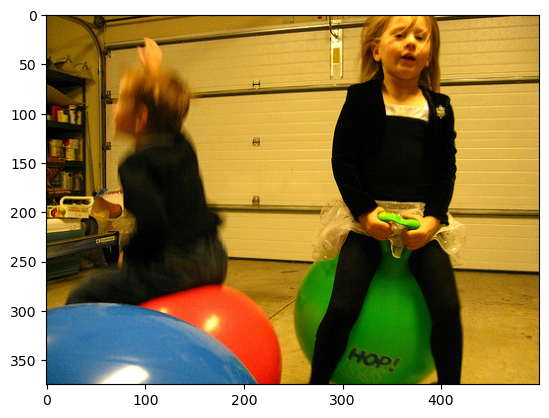

In [20]:
generate_caption("2160266952_a2ab39191b.jpg",model)

---------------------Actual---------------------
startseq man drives an atv down dirt road with power line behind him endseq
startseq man is driving red atv up rugged hill endseq
startseq man wearing white hat is on red atv driving on the dirt endseq
startseq man riding fourwheel offroad vehicle in rural area endseq
startseq the man rides his quad through rural area followed by his dog endseq
--------------------Predicted--------------------
startseq man in red shirt is sitting on the mud endseq






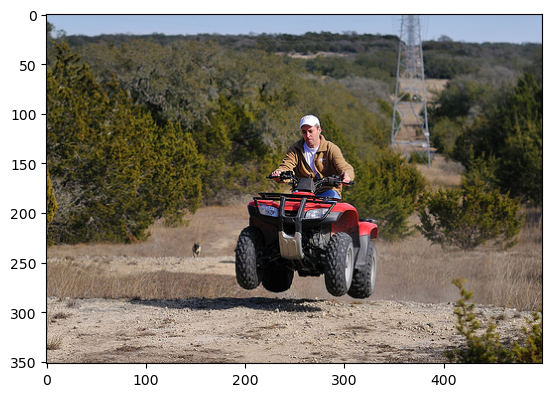

In [21]:
generate_caption("3247052319_da8aba1983.jpg",model)